In [1]:
import random, gc, os, pickle, csv, time

import datasets.utils
import models.utils
from models.cls_oml_ori_v2 import OML
from models.base_models_ori import LabelAwareReplayMemory

import numpy as np
import matplotlib.pyplot as plt

import higher
import torch
import torch.nn.functional as F
from torch.utils import data

# Constants

In [2]:
dataset_order_mapping = {
    1: [2, 0, 3, 1, 4],
    2: [3, 4, 0, 1, 2],
    3: [2, 4, 1, 3, 0],
    4: [0, 2, 1, 4, 3]
}
n_classes = 33
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518612.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456804.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477968.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869765.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241546.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424113.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167637.pt"

# v. SR 
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695669.pt"
# v. SR Query
model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228.pt"

# memory_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518639_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456828_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477992_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869797_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241572_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424139_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167666_memory.pickle"
# v. SR 
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695692_memory.pickle"
# v. SR Query
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854254_memory.pickle"


# new_memory_path, ext = os.path.splitext(memory_path)
# new_memory_path = new_memory_path + "_label" + ext

use_db_cache = True
cache_dir = 'tmp'

In [3]:
args = {
    "order": 1,
    "n_epochs": 1,
    "lr": 3e-5,
    "inner_lr": 0.001*10,
    "meta_lr": 3e-5,
    "model": "bert",
    "learner": "oml",
    "mini_batch_size": 16,
    "updates": 5*1,
    "write_prob": 1.0,
    "max_length": 448,
    "seed": 42,
    "replay_rate": 0.01,
    "replay_every": 9600
}
updates = args["updates"]
mini_batch_size = args["mini_batch_size"]
order = args["order"]

In [4]:
torch.manual_seed(args["seed"])
random.seed(args["seed"])
np.random.seed(args["seed"])

# Load Dataset

In [5]:
print('Loading the datasets')
test_datasets = []
for dataset_id in dataset_order_mapping[order]:
    test_dataset_file = os.path.join(cache_dir, f"{dataset_id}.cache")
    if os.path.exists(test_dataset_file):
        with open(test_dataset_file, 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = datasets.utils.get_dataset_test("", dataset_id)
        print('Loaded {}'.format(test_dataset.__class__.__name__))
        test_dataset = datasets.utils.offset_labels(test_dataset)
        pickle.dump(test_dataset, open( test_dataset_file, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Pickle saved at {test_dataset_file}")
    test_datasets.append(test_dataset)
print('Finished loading all the datasets')

Loading the datasets
Finished loading all the datasets


# Load Model

In [6]:
learner = OML(device=device, n_classes=n_classes, **args)
print('Using {} as learner'.format(learner.__class__.__name__))
learner.load_model(model_path)
with open(memory_path, 'rb') as f:
#     learner.memory = pickle.load(f)
    memory_buffer = pickle.load(f)


2022-11-27 22:20:57,338 - transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2022-11-27 22:20:58,580 - transformers.configuration_utils - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2022-11-27 22:20:58,584 - transformers.configuration_utils - INFO - Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

Using OML as learner


In [7]:
# Setting up task dict for task-aware
memory_buffer.task_dict = {
    0: list(range(5, 9)), # AG
    1: list(range(0, 5)), # Amazon
    2: list(range(0, 5)), # Yelp
    3: list(range(9, 23)), # DBPedia
    4: list(range(23, 33)), # Yahoo
}

In [8]:
# label to task converter - hack, since normally we would just use the task token/identifier
def get_task_from_label(label_idx, task_dict):
    for task_idx, class_list in task_dict.items():
        if label_idx in class_list: return task_idx
    return -1
print(get_task_from_label(8, memory_buffer.task_dict))
# Find mode: https://stackoverflow.com/questions/10797819/finding-the-mode-of-a-list
def mode(array):
    return max(array, key = array.count)
# label list to task id
def get_task_from_label_list(label_list, task_dict):
    return mode([get_task_from_label(label, task_dict) for label in label_list])
print(get_task_from_label_list([1,2,32,1,4,2,0], memory_buffer.task_dict))

0
1


In [9]:
dataclass_mapper = {
    "AGNewsDataset": 0,
    "AmazonDataset": 1,
    "YelpDataset": 2,
    "DBPediaDataset": 3,
    "YahooAnswersDataset": 4
}
dataclass_mapper["AGNewsDataset"]

0

In [10]:
# Trim buffer dict to 1000 per class
memory_buffer.reset_meta()
memory_buffer.trim_buffer_dict()

In [11]:
len(memory_buffer.buffer_dict[0])

1000

# Get Scores for each sample in ER

In [12]:
# Returns loss,preds,labels, labels_conf
def validate(fpln, validation_set):
    all_valid_preds, all_valid_labels, all_valid_label_conf = [], [], []
    
    for valid_text, valid_labels, _ in validation_set:        
        valid_labels = torch.tensor(valid_labels).to(device)
        valid_input_dict = learner.rln.encode_text(valid_text)
        valid_repr = learner.rln(valid_input_dict)
        valid_output = fpln(valid_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
        valid_loss = learner.loss_fn(valid_output, valid_labels)
        valid_loss = valid_loss.item()

        # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
        valid_output_softmax = F.softmax(valid_output, -1)
        valid_label_conf = valid_output_softmax[np.arange(len(valid_output_softmax)), valid_labels] # Select labels in the softmax of 33 classes

        valid_pred = models.utils.make_prediction(valid_output.detach())
        
        
        # Put in things to return
        # all_valid_losses.extend(valid_loss)
        all_valid_preds.extend(valid_pred.tolist())
        all_valid_labels.extend(valid_labels.tolist())
        all_valid_label_conf.extend(valid_label_conf.tolist())
    return all_valid_preds, all_valid_labels, all_valid_label_conf # removed loss, since no need

# Compare diff results between the unadapted vs adapted
# Returns Dictionary of class_idx -> [ a - n, ...  ] for each i (300). Can np.sum() or np.mean() later
# validate_labels = The labels (Shared)
# validate_label_conf_0 = The label conf of validate_0
# validate_label_conf_n = The label conf of validate_n
def calculate_diff_class(validate_labels, validate_label_conf_0, validate_label_conf_n, initial_dict={}, return_dict=True): 
    # Adapted confs - NonAdapted Confs (a-n)
    validate_label_conf_diff = np.array(validate_label_conf_n) - np.array(validate_label_conf_0)
    
    if return_dict:
        # The dictionary to return  class_idx -> [ a - n, ...  ] 
        return_dict = initial_dict.copy()
        for i, class_idx in enumerate(validate_labels):
            # Filter conf_diff by class
            return_dict[class_idx] = return_dict.get(class_idx, []) + [validate_label_conf_diff[i]]
        return return_dict
    
    return validate_label_conf_diff

Every Task, we do `16*5 = 80` batch , there are 5 tasks so `80*5 = 400` per epoch (takes around 1s per task ~5s). So we need to do it 60 times so that it will be ~5 minutes (300s) and it means `400*60 = 24,000`, and hopefully support will be around ~24 per sample.

```
Adapt Time: 0.861821174621582 s
Support set metrics: Loss = 0.1350, accuracy = 0.9625, precision = 0.9643, recall = 0.9643, F1 score = 0.9609
```

In [13]:
for epoch in range(50):
    print(f"This is epoch {epoch}/50")
    learner.rln.eval()
    learner.pln.train()
    
    for task_idx in memory_buffer.task_dict.keys():
        support_set = []
        for _ in range(updates):
            text, labels, indexes = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, \
                                                                  with_index=True)
            support_set.append((text, labels, indexes))
        
        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            # Test validation_set BEFORE the update (update=0)
            with torch.no_grad():
                all_valid_preds_0, all_valid_labels_0, all_valid_label_conf_0  = validate(fpln, support_set)
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels, task_indexes = [], [], []
            support_loss = []
            for text, labels, indexes in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
                task_indexes.extend(indexes)
            INNER_toc = time.time() - INNER_tic
            print("Adapt Time: "+ str(INNER_toc) +" s" )
            
            # Test validation_set AFTER ALL the update
            with torch.no_grad():
                all_valid_preds_n, all_valid_labels_n, all_valid_label_conf_n = validate(fpln, support_set)
                diff_list = calculate_diff_class(all_valid_labels_0, all_valid_label_conf_0, all_valid_label_conf_n, return_dict=False)
                memory_buffer.update_meta(all_valid_labels_0, task_indexes, diff_list)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

This is epoch 0/50
Adapt Time: 0.8428223133087158 s
Support set metrics: Loss = 0.2452, accuracy = 0.9125, precision = 0.9160, recall = 0.9125, F1 score = 0.9122
Adapt Time: 1.0216925144195557 s
Support set metrics: Loss = 0.9790, accuracy = 0.6625, precision = 0.6759, recall = 0.6600, F1 score = 0.6650
Adapt Time: 0.9592475891113281 s
Support set metrics: Loss = 0.8322, accuracy = 0.6125, precision = 0.6062, recall = 0.6067, F1 score = 0.5986
Adapt Time: 0.8662240505218506 s
Support set metrics: Loss = 0.0256, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Adapt Time: 0.9996945858001709 s
Support set metrics: Loss = 0.8100, accuracy = 0.7000, precision = 0.7087, recall = 0.6800, F1 score = 0.6777
This is epoch 1/50
Adapt Time: 0.8222825527191162 s
Support set metrics: Loss = 0.3506, accuracy = 0.8500, precision = 0.8540, recall = 0.8500, F1 score = 0.8486
Adapt Time: 1.0102953910827637 s
Support set metrics: Loss = 0.9581, accuracy = 0.6500, precision = 0.65

Adapt Time: 0.9438953399658203 s
Support set metrics: Loss = 0.8360, accuracy = 0.6750, precision = 0.6956, recall = 0.6767, F1 score = 0.6816
Adapt Time: 0.952232837677002 s
Support set metrics: Loss = 0.8947, accuracy = 0.6625, precision = 0.6766, recall = 0.6567, F1 score = 0.6641
Adapt Time: 0.858457088470459 s
Support set metrics: Loss = 0.0091, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 1.0683071613311768 s
Support set metrics: Loss = 0.8621, accuracy = 0.7875, precision = 0.7992, recall = 0.7800, F1 score = 0.7756
This is epoch 12/50
Adapt Time: 0.8354241847991943 s
Support set metrics: Loss = 0.2327, accuracy = 0.9125, precision = 0.9120, recall = 0.9125, F1 score = 0.9111
Adapt Time: 0.9646029472351074 s
Support set metrics: Loss = 0.9437, accuracy = 0.5750, precision = 0.5519, recall = 0.5567, F1 score = 0.5527
Adapt Time: 0.921281099319458 s
Support set metrics: Loss = 0.9349, accuracy = 0.6625, precision = 0.6821, recall = 0.6567, 

Adapt Time: 0.9242715835571289 s
Support set metrics: Loss = 1.0597, accuracy = 0.6625, precision = 0.6900, recall = 0.6567, F1 score = 0.6671
Adapt Time: 0.8503577709197998 s
Support set metrics: Loss = 0.0832, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Adapt Time: 1.0346379280090332 s
Support set metrics: Loss = 0.7770, accuracy = 0.7875, precision = 0.8019, recall = 0.7800, F1 score = 0.7829
This is epoch 23/50
Adapt Time: 0.8215103149414062 s
Support set metrics: Loss = 0.2846, accuracy = 0.8500, precision = 0.8521, recall = 0.8500, F1 score = 0.8505
Adapt Time: 1.0069780349731445 s
Support set metrics: Loss = 0.7825, accuracy = 0.7125, precision = 0.7474, recall = 0.7133, F1 score = 0.7190
Adapt Time: 0.9836537837982178 s
Support set metrics: Loss = 0.8043, accuracy = 0.6500, precision = 0.6604, recall = 0.6433, F1 score = 0.6464
Adapt Time: 0.8605232238769531 s
Support set metrics: Loss = 0.0222, accuracy = 0.9875, precision = 0.9881, recall = 0.992

Adapt Time: 0.87074875831604 s
Support set metrics: Loss = 0.0185, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Adapt Time: 0.9937214851379395 s
Support set metrics: Loss = 0.8416, accuracy = 0.6750, precision = 0.6767, recall = 0.6800, F1 score = 0.6706
This is epoch 34/50
Adapt Time: 0.8336803913116455 s
Support set metrics: Loss = 0.3307, accuracy = 0.8875, precision = 0.8866, recall = 0.8875, F1 score = 0.8820
Adapt Time: 1.0660605430603027 s
Support set metrics: Loss = 1.0581, accuracy = 0.5750, precision = 0.5698, recall = 0.5533, F1 score = 0.5557
Adapt Time: 0.9567544460296631 s
Support set metrics: Loss = 0.9273, accuracy = 0.6125, precision = 0.6075, recall = 0.6033, F1 score = 0.6018
Adapt Time: 0.8724913597106934 s
Support set metrics: Loss = 0.1923, accuracy = 0.9750, precision = 0.9810, recall = 0.9786, F1 score = 0.9784
Adapt Time: 1.002561330795288 s
Support set metrics: Loss = 1.0612, accuracy = 0.7500, precision = 0.7009, recall = 0.7100, 

Adapt Time: 0.9946103096008301 s
Support set metrics: Loss = 0.7343, accuracy = 0.7500, precision = 0.7670, recall = 0.7600, F1 score = 0.7514
This is epoch 45/50
Adapt Time: 0.8287720680236816 s
Support set metrics: Loss = 0.2135, accuracy = 0.9125, precision = 0.9143, recall = 0.9125, F1 score = 0.9123
Adapt Time: 0.9958961009979248 s
Support set metrics: Loss = 0.8737, accuracy = 0.6500, precision = 0.6451, recall = 0.6433, F1 score = 0.6430
Adapt Time: 0.9654085636138916 s
Support set metrics: Loss = 0.9045, accuracy = 0.6750, precision = 0.6729, recall = 0.6633, F1 score = 0.6662
Adapt Time: 0.8624825477600098 s
Support set metrics: Loss = 0.0835, accuracy = 0.9875, precision = 0.9881, recall = 0.9857, F1 score = 0.9856
Adapt Time: 0.9958405494689941 s
Support set metrics: Loss = 0.8339, accuracy = 0.7875, precision = 0.7711, recall = 0.7500, F1 score = 0.7474
This is epoch 46/50
Adapt Time: 0.8368124961853027 s
Support set metrics: Loss = 0.0773, accuracy = 1.0000, precision = 1.

In [14]:
print("Support of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    total_support = np.sum(memory_buffer.meta_score[class_idx, ..., 1])
    mean_support = np.mean(memory_buffer.meta_score[class_idx, ..., 1])
    print(f"\t#Class {class_idx}: {total_support} , Avg: {mean_support}")

Support of each class: 
	#Class 0: 1982.0 , Avg: 1.982
	#Class 1: 1492.0 , Avg: 1.492
	#Class 2: 1489.0 , Avg: 1.489
	#Class 3: 1492.0 , Avg: 1.492
	#Class 4: 1492.0 , Avg: 1.492
	#Class 5: 992.0 , Avg: 0.992
	#Class 6: 993.0 , Avg: 0.993
	#Class 7: 982.0 , Avg: 0.982
	#Class 8: 989.0 , Avg: 0.989
	#Class 9: 500.0 , Avg: 0.5
	#Class 10: 499.0 , Avg: 0.499
	#Class 11: 250.0 , Avg: 0.25
	#Class 12: 250.0 , Avg: 0.25
	#Class 13: 250.0 , Avg: 0.25
	#Class 14: 249.0 , Avg: 0.249
	#Class 15: 250.0 , Avg: 0.25
	#Class 16: 250.0 , Avg: 0.25
	#Class 17: 249.0 , Avg: 0.249
	#Class 18: 250.0 , Avg: 0.25
	#Class 19: 250.0 , Avg: 0.25
	#Class 20: 250.0 , Avg: 0.25
	#Class 21: 250.0 , Avg: 0.25
	#Class 22: 250.0 , Avg: 0.25
	#Class 23: 497.0 , Avg: 0.497
	#Class 24: 496.0 , Avg: 0.496
	#Class 25: 499.0 , Avg: 0.499
	#Class 26: 499.0 , Avg: 0.499
	#Class 27: 499.0 , Avg: 0.499
	#Class 28: 499.0 , Avg: 0.499
	#Class 29: 250.0 , Avg: 0.25
	#Class 30: 249.0 , Avg: 0.249
	#Class 31: 249.0 , Avg: 0.249
	#

In [15]:
print("Average Score of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    #mean_score = np.mean(memory_buffer.meta_score[class_idx, ..., 0])
    mean_score = np.mean(memory_buffer.meta_score[class_idx][memory_buffer.meta_score[class_idx, ...,1] != 0][..., 0])
    print(f"\tScore Class {class_idx}: {mean_score}")

Average Score of each class: 
	Score Class 0: 0.023047585013053574
	Score Class 1: 0.007221251265793565
	Score Class 2: 0.005757247094514334
	Score Class 3: -0.0007426267472351063
	Score Class 4: -0.009796088760150784
	Score Class 5: 0.001870844344604575
	Score Class 6: -0.0001808710622823937
	Score Class 7: 0.01523618331027173
	Score Class 8: -0.012064803141358162
	Score Class 9: 0.0004404090716524727
	Score Class 10: 0.00033930742146760003
	Score Class 11: 0.00015723143171688373
	Score Class 12: -5.226359303508485e-06
	Score Class 13: 0.0005918316694400606
	Score Class 14: 0.00014257884408262644
	Score Class 15: 0.00021360929754844521
	Score Class 16: 0.00016366951264344256
	Score Class 17: -1.5857396104410624e-06
	Score Class 18: 0.00021188609226268122
	Score Class 19: -6.3539359057061015e-06
	Score Class 20: 0.00012866346339514064
	Score Class 21: 6.451000430517726e-05
	Score Class 22: -2.9982080286983986e-05
	Score Class 23: -0.0007765641120214859
	Score Class 24: 0.01706983946724

In [16]:
print(memory_buffer.meta_score[0].shape)
print(memory_buffer.meta_score[0][memory_buffer.meta_score[0, ...,1] != 0].shape)

(1000, 2)
(870, 2)


### Plotting Distribution of Scores for each Class

(array([  2.,   0.,   1.,   1.,   2.,   3.,   8.,  15.,  26.,  29.,  74.,
        163., 640.,  31.,   5.]),
 array([-0.13530234, -0.12452662, -0.1137509 , -0.10297519, -0.09219947,
        -0.08142375, -0.07064804, -0.05987232, -0.04909661, -0.03832089,
        -0.02754517, -0.01676946, -0.00599374,  0.00478197,  0.01555769,
         0.02633341]),
 <BarContainer object of 15 artists>)

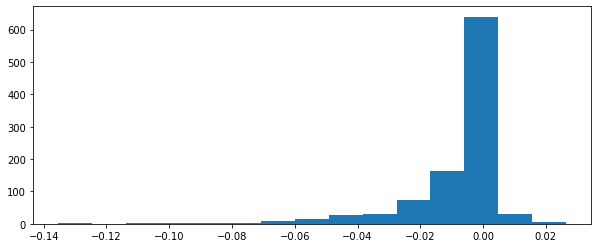

In [17]:
class_idx = 8
score_list = memory_buffer.meta_score[class_idx, ..., 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

### Plotting Distribution of Scores for one sample

(array([ 2.,  3.,  0.,  2.,  9., 29., 19.,  6.,  5.,  8.,  7.,  4.,  1.,
         1.,  4.]),
 array([-0.09207225, -0.0729775 , -0.05388275, -0.034788  , -0.01569325,
         0.0034015 ,  0.02249625,  0.041591  ,  0.06068575,  0.0797805 ,
         0.09887524,  0.11796999,  0.13706474,  0.15615949,  0.17525424,
         0.19434899]),
 <BarContainer object of 15 artists>)

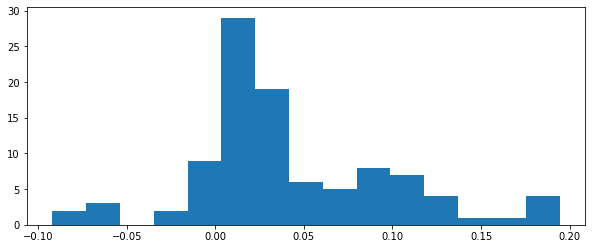

In [18]:
class_idx = 0
score_list = memory_buffer.meta_debug[class_idx][0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

# Testing

Select specific column index per row
https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes

In [19]:
def evaluate(dataloader, updates, mini_batch_size, dataname=""):
    learner.rln.eval()
    learner.pln.train()
    
    all_losses, all_predictions, all_labels, all_label_conf = [], [], [], []
    all_adaptation_time = []
    # Get Query set first. and then find supporting support set
    for query_idx, (query_text, query_labels) in enumerate(dataloader):
        print(f"Query ID {query_idx}/{len(dataloader)}")
        # The task id to optimize to for support set
        # task_idx = get_task_from_label_list(query_labels, memory_buffer.task_dict)
        task_idx = dataclass_mapper[dataname]
        
    
        support_set = []
        for _ in range(updates):
            text, labels = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, sort_score=True)
            support_set.append((text, labels))

        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels = [], []
            support_loss = []
            for text, labels in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
            INNER_toc = time.time() - INNER_tic
            all_adaptation_time.append(INNER_toc)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

            # Query set is now here!
            query_labels = torch.tensor(query_labels).to(device)
            query_input_dict = learner.rln.encode_text(query_text)
            with torch.no_grad():
                query_repr = learner.rln(query_input_dict)
                query_output = fpln(query_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
                query_loss = learner.loss_fn(query_output, query_labels)
            query_loss = query_loss.item()
            # print(output.detach().size())
            # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
            query_output_softmax = F.softmax(query_output, -1)
            query_label_conf = query_output_softmax[np.arange(len(query_output_softmax)), query_labels] # Select labels in the softmax of 33 classes

            query_pred = models.utils.make_prediction(query_output.detach())
            query_acc, query_prec, query_rec, query_f1 = models.utils.calculate_metrics(query_pred.tolist(), query_labels.tolist())
            
            print('Query set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(query_loss), query_acc, query_prec, query_rec, query_f1))

            all_losses.append(query_loss)
            all_predictions.extend(query_pred.tolist())
            all_labels.extend(query_labels.tolist())
            all_label_conf.extend(query_label_conf.tolist())

    acc, prec, rec, f1 = models.utils.calculate_metrics(all_predictions, all_labels)
    print('Test metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
                'F1 score = {:.4f}'.format(np.mean(all_losses), acc, prec, rec, f1))
    return acc, prec, rec, f1, all_predictions, all_labels, all_label_conf, all_adaptation_time

In [20]:
tic = time.time()
print('----------Testing on test set starts here----------')

accuracies, precisions, recalls, f1s = [], [], [], []
all_adapt_time = []
# Data for Visualization: [data_idx, label, label_conf, pred]
data_for_visual = []

for test_dataset in test_datasets:
    print('Testing on {}'.format(test_dataset.__class__.__name__))
    test_dataloader = data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False,
                                      collate_fn=datasets.utils.batch_encode)
    acc, prec, rec, f1, all_pred, all_label, all_label_conf, all_adaptation_time = evaluate(dataloader=test_dataloader, updates=updates, 
                                                mini_batch_size=mini_batch_size, dataname=test_dataset.__class__.__name__)
    
    data_ids = [test_dataset.__class__.__name__ + str(i) for i in range(len(all_label))]
    data_for_visual.extend(list(zip(data_ids, all_label, all_label_conf, all_pred)))
    all_adapt_time.extend(all_adaptation_time)
#     print(data_ids)
#     print(all_label)
#     raise Exception("BREAKPOINT")
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)


print()
print("COPY PASTA - not really but ok")
for row in accuracies:
    print(row)
print()
print('Overall test metrics: Accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
            'F1 score = {:.4f}'.format(np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)))

toc = time.time() - tic
print(f"Total Time used: {toc//60} minutes")

----------Testing on test set starts here----------
Testing on YelpDataset
Query ID 0/475
Support set metrics: Loss = 0.7738, accuracy = 0.7375, precision = 0.7579, recall = 0.7333, F1 score = 0.7421
Query set metrics: Loss = 0.6284, accuracy = 0.6875, precision = 0.7800, recall = 0.6933, F1 score = 0.6900
Query ID 1/475
Support set metrics: Loss = 0.8496, accuracy = 0.7000, precision = 0.7152, recall = 0.6900, F1 score = 0.6944
Query set metrics: Loss = 0.7303, accuracy = 0.7500, precision = 0.7267, recall = 0.7933, F1 score = 0.7200
Query ID 2/475
Support set metrics: Loss = 0.8843, accuracy = 0.6750, precision = 0.6805, recall = 0.6667, F1 score = 0.6728
Query set metrics: Loss = 0.9050, accuracy = 0.5625, precision = 0.5800, recall = 0.5833, F1 score = 0.5610
Query ID 3/475
Support set metrics: Loss = 0.8323, accuracy = 0.6875, precision = 0.6791, recall = 0.6733, F1 score = 0.6696
Query set metrics: Loss = 0.8994, accuracy = 0.6250, precision = 0.6200, recall = 0.6000, F1 score = 

Support set metrics: Loss = 0.8297, accuracy = 0.6375, precision = 0.6333, recall = 0.6233, F1 score = 0.6222
Query set metrics: Loss = 0.6902, accuracy = 0.7500, precision = 0.7625, recall = 0.7625, F1 score = 0.7625
Query ID 36/475
Support set metrics: Loss = 0.7675, accuracy = 0.6875, precision = 0.6894, recall = 0.6767, F1 score = 0.6779
Query set metrics: Loss = 0.8630, accuracy = 0.7500, precision = 0.7000, recall = 0.7500, F1 score = 0.7048
Query ID 37/475
Support set metrics: Loss = 0.9883, accuracy = 0.6375, precision = 0.6416, recall = 0.6333, F1 score = 0.6348
Query set metrics: Loss = 0.6632, accuracy = 0.7500, precision = 0.6333, recall = 0.6433, F1 score = 0.6325
Query ID 38/475
Support set metrics: Loss = 0.8642, accuracy = 0.6000, precision = 0.5955, recall = 0.5833, F1 score = 0.5867
Query set metrics: Loss = 0.8190, accuracy = 0.5625, precision = 0.4700, recall = 0.5700, F1 score = 0.5100
Query ID 39/475
Support set metrics: Loss = 0.8537, accuracy = 0.7125, precision

Query set metrics: Loss = 1.3402, accuracy = 0.3750, precision = 0.4024, recall = 0.4600, F1 score = 0.3633
Query ID 71/475
Support set metrics: Loss = 1.0216, accuracy = 0.6125, precision = 0.6228, recall = 0.6000, F1 score = 0.6067
Query set metrics: Loss = 0.9568, accuracy = 0.5625, precision = 0.6033, recall = 0.4833, F1 score = 0.4967
Query ID 72/475
Support set metrics: Loss = 1.0003, accuracy = 0.5875, precision = 0.6097, recall = 0.5867, F1 score = 0.5931
Query set metrics: Loss = 0.6771, accuracy = 0.6250, precision = 0.6000, recall = 0.5800, F1 score = 0.5867
Query ID 73/475
Support set metrics: Loss = 0.7519, accuracy = 0.6500, precision = 0.6533, recall = 0.6433, F1 score = 0.6423
Query set metrics: Loss = 0.8404, accuracy = 0.8125, precision = 0.7100, recall = 0.7200, F1 score = 0.7111
Query ID 74/475
Support set metrics: Loss = 0.8864, accuracy = 0.6500, precision = 0.6624, recall = 0.6367, F1 score = 0.6444
Query set metrics: Loss = 0.8974, accuracy = 0.7500, precision =

Query set metrics: Loss = 0.6827, accuracy = 0.6250, precision = 0.6167, recall = 0.6000, F1 score = 0.6024
Query ID 106/475
Support set metrics: Loss = 0.9585, accuracy = 0.6375, precision = 0.6353, recall = 0.6300, F1 score = 0.6288
Query set metrics: Loss = 1.2416, accuracy = 0.3125, precision = 0.3300, recall = 0.4000, F1 score = 0.3432
Query ID 107/475
Support set metrics: Loss = 0.7125, accuracy = 0.7125, precision = 0.7178, recall = 0.7033, F1 score = 0.7012
Query set metrics: Loss = 0.9248, accuracy = 0.5000, precision = 0.6000, recall = 0.5000, F1 score = 0.4933
Query ID 108/475
Support set metrics: Loss = 0.8523, accuracy = 0.6750, precision = 0.6853, recall = 0.6667, F1 score = 0.6709
Query set metrics: Loss = 1.1360, accuracy = 0.3750, precision = 0.4000, recall = 0.3400, F1 score = 0.3000
Query ID 109/475
Support set metrics: Loss = 0.7366, accuracy = 0.7125, precision = 0.7132, recall = 0.7000, F1 score = 0.6988
Query set metrics: Loss = 0.9866, accuracy = 0.4375, precisi

Query set metrics: Loss = 0.5272, accuracy = 0.8125, precision = 0.8500, recall = 0.8533, F1 score = 0.8267
Query ID 141/475
Support set metrics: Loss = 0.8395, accuracy = 0.7125, precision = 0.7220, recall = 0.7067, F1 score = 0.7114
Query set metrics: Loss = 0.7787, accuracy = 0.6250, precision = 0.6900, recall = 0.6000, F1 score = 0.6071
Query ID 142/475
Support set metrics: Loss = 0.8980, accuracy = 0.5750, precision = 0.5658, recall = 0.5600, F1 score = 0.5589
Query set metrics: Loss = 0.6980, accuracy = 0.8125, precision = 0.6833, recall = 0.7500, F1 score = 0.7100
Query ID 143/475
Support set metrics: Loss = 0.8229, accuracy = 0.6375, precision = 0.6055, recall = 0.6167, F1 score = 0.6055
Query set metrics: Loss = 0.6565, accuracy = 0.6875, precision = 0.7133, recall = 0.6933, F1 score = 0.6663
Query ID 144/475
Support set metrics: Loss = 0.7469, accuracy = 0.7250, precision = 0.7305, recall = 0.7200, F1 score = 0.7141
Query set metrics: Loss = 0.9972, accuracy = 0.6250, precisi

Query set metrics: Loss = 0.8878, accuracy = 0.5625, precision = 0.5867, recall = 0.5200, F1 score = 0.4889
Query ID 176/475
Support set metrics: Loss = 0.8591, accuracy = 0.6250, precision = 0.6270, recall = 0.6167, F1 score = 0.6196
Query set metrics: Loss = 0.9703, accuracy = 0.5000, precision = 0.5167, recall = 0.4667, F1 score = 0.4814
Query ID 177/475
Support set metrics: Loss = 1.0585, accuracy = 0.6250, precision = 0.6586, recall = 0.6167, F1 score = 0.6326
Query set metrics: Loss = 0.8584, accuracy = 0.6250, precision = 0.8167, recall = 0.7333, F1 score = 0.7000
Query ID 178/475
Support set metrics: Loss = 1.0123, accuracy = 0.5875, precision = 0.5882, recall = 0.5800, F1 score = 0.5742
Query set metrics: Loss = 1.1023, accuracy = 0.4375, precision = 0.4143, recall = 0.4600, F1 score = 0.4333
Query ID 179/475
Support set metrics: Loss = 0.8089, accuracy = 0.7375, precision = 0.7511, recall = 0.7267, F1 score = 0.7257
Query set metrics: Loss = 0.8785, accuracy = 0.4375, precisi

Query set metrics: Loss = 1.2011, accuracy = 0.5625, precision = 0.6667, recall = 0.5833, F1 score = 0.5533
Query ID 211/475
Support set metrics: Loss = 0.6641, accuracy = 0.8000, precision = 0.8024, recall = 0.7933, F1 score = 0.7917
Query set metrics: Loss = 1.0417, accuracy = 0.5625, precision = 0.7500, recall = 0.6333, F1 score = 0.5333
Query ID 212/475
Support set metrics: Loss = 0.9738, accuracy = 0.5875, precision = 0.5637, recall = 0.5767, F1 score = 0.5674
Query set metrics: Loss = 0.8006, accuracy = 0.6250, precision = 0.6867, recall = 0.6500, F1 score = 0.6286
Query ID 213/475
Support set metrics: Loss = 0.9302, accuracy = 0.6250, precision = 0.6544, recall = 0.6100, F1 score = 0.6207
Query set metrics: Loss = 0.6516, accuracy = 0.7500, precision = 0.5833, recall = 0.6500, F1 score = 0.5985
Query ID 214/475
Support set metrics: Loss = 0.9708, accuracy = 0.6625, precision = 0.6826, recall = 0.6533, F1 score = 0.6600
Query set metrics: Loss = 0.9395, accuracy = 0.6875, precisi

Support set metrics: Loss = 0.8072, accuracy = 0.6500, precision = 0.6567, recall = 0.6400, F1 score = 0.6452
Query set metrics: Loss = 0.8787, accuracy = 0.6875, precision = 0.6867, recall = 0.7000, F1 score = 0.6790
Query ID 247/475
Support set metrics: Loss = 0.7967, accuracy = 0.6625, precision = 0.6440, recall = 0.6467, F1 score = 0.6393
Query set metrics: Loss = 1.1320, accuracy = 0.6875, precision = 0.7533, recall = 0.7200, F1 score = 0.6810
Query ID 248/475
Support set metrics: Loss = 0.8115, accuracy = 0.6625, precision = 0.6669, recall = 0.6600, F1 score = 0.6592
Query set metrics: Loss = 0.8603, accuracy = 0.5625, precision = 0.6000, recall = 0.6000, F1 score = 0.5914
Query ID 249/475
Support set metrics: Loss = 0.9913, accuracy = 0.6625, precision = 0.7058, recall = 0.6500, F1 score = 0.6707
Query set metrics: Loss = 0.8982, accuracy = 0.6875, precision = 0.8000, recall = 0.7810, F1 score = 0.7121
Query ID 250/475
Support set metrics: Loss = 0.8163, accuracy = 0.6875, preci

Support set metrics: Loss = 0.8207, accuracy = 0.7000, precision = 0.7135, recall = 0.6900, F1 score = 0.6977
Query set metrics: Loss = 0.8615, accuracy = 0.5625, precision = 0.6133, recall = 0.6933, F1 score = 0.5743
Query ID 282/475
Support set metrics: Loss = 0.8867, accuracy = 0.6125, precision = 0.6002, recall = 0.6000, F1 score = 0.5983
Query set metrics: Loss = 0.9652, accuracy = 0.6250, precision = 0.6167, recall = 0.7000, F1 score = 0.6333
Query ID 283/475
Support set metrics: Loss = 0.8895, accuracy = 0.6500, precision = 0.6574, recall = 0.6367, F1 score = 0.6418
Query set metrics: Loss = 1.0341, accuracy = 0.5625, precision = 0.6300, recall = 0.5500, F1 score = 0.5522
Query ID 284/475
Support set metrics: Loss = 0.7293, accuracy = 0.7375, precision = 0.7491, recall = 0.7300, F1 score = 0.7312
Query set metrics: Loss = 0.6515, accuracy = 0.6875, precision = 0.7400, recall = 0.7810, F1 score = 0.7267
Query ID 285/475
Support set metrics: Loss = 0.8915, accuracy = 0.6750, preci

Support set metrics: Loss = 0.8342, accuracy = 0.6250, precision = 0.6274, recall = 0.6133, F1 score = 0.6117
Query set metrics: Loss = 0.5780, accuracy = 0.6875, precision = 0.7000, recall = 0.6333, F1 score = 0.6467
Query ID 317/475
Support set metrics: Loss = 0.8161, accuracy = 0.7000, precision = 0.7286, recall = 0.6933, F1 score = 0.7069
Query set metrics: Loss = 0.8396, accuracy = 0.6875, precision = 0.7000, recall = 0.6333, F1 score = 0.6133
Query ID 318/475
Support set metrics: Loss = 0.8957, accuracy = 0.6250, precision = 0.6214, recall = 0.6033, F1 score = 0.6065
Query set metrics: Loss = 0.9570, accuracy = 0.5625, precision = 0.5500, recall = 0.6000, F1 score = 0.5048
Query ID 319/475
Support set metrics: Loss = 0.9969, accuracy = 0.5500, precision = 0.5422, recall = 0.5367, F1 score = 0.5380
Query set metrics: Loss = 0.9698, accuracy = 0.7500, precision = 0.7333, recall = 0.7500, F1 score = 0.7286
Query ID 320/475
Support set metrics: Loss = 0.7242, accuracy = 0.6875, preci

Support set metrics: Loss = 0.8587, accuracy = 0.6750, precision = 0.6680, recall = 0.6533, F1 score = 0.6470
Query set metrics: Loss = 1.1834, accuracy = 0.5625, precision = 0.6667, recall = 0.5524, F1 score = 0.5867
Query ID 352/475
Support set metrics: Loss = 0.8849, accuracy = 0.6875, precision = 0.6837, recall = 0.6767, F1 score = 0.6774
Query set metrics: Loss = 0.7063, accuracy = 0.8125, precision = 0.8083, recall = 0.8000, F1 score = 0.7467
Query ID 353/475
Support set metrics: Loss = 0.9244, accuracy = 0.6125, precision = 0.5953, recall = 0.6033, F1 score = 0.5922
Query set metrics: Loss = 1.2744, accuracy = 0.3750, precision = 0.4300, recall = 0.2667, F1 score = 0.3089
Query ID 354/475
Support set metrics: Loss = 0.9225, accuracy = 0.7375, precision = 0.7555, recall = 0.7267, F1 score = 0.7238
Query set metrics: Loss = 0.8493, accuracy = 0.6875, precision = 0.6600, recall = 0.7200, F1 score = 0.6421
Query ID 355/475
Support set metrics: Loss = 0.7118, accuracy = 0.6875, preci

Support set metrics: Loss = 0.7907, accuracy = 0.7125, precision = 0.7260, recall = 0.7133, F1 score = 0.7162
Query set metrics: Loss = 1.0002, accuracy = 0.5000, precision = 0.5833, recall = 0.5467, F1 score = 0.5127
Query ID 387/475
Support set metrics: Loss = 0.7756, accuracy = 0.6875, precision = 0.6882, recall = 0.6800, F1 score = 0.6818
Query set metrics: Loss = 1.3934, accuracy = 0.6250, precision = 0.5200, recall = 0.5095, F1 score = 0.4967
Query ID 388/475
Support set metrics: Loss = 0.8268, accuracy = 0.6875, precision = 0.6758, recall = 0.6800, F1 score = 0.6770
Query set metrics: Loss = 0.7052, accuracy = 0.6875, precision = 0.7733, recall = 0.7167, F1 score = 0.6654
Query ID 389/475
Support set metrics: Loss = 0.7905, accuracy = 0.6875, precision = 0.6972, recall = 0.6700, F1 score = 0.6779
Query set metrics: Loss = 0.8840, accuracy = 0.6250, precision = 0.6000, recall = 0.7000, F1 score = 0.6057
Query ID 390/475
Support set metrics: Loss = 0.7458, accuracy = 0.6875, preci

Query ID 421/475
Support set metrics: Loss = 0.8188, accuracy = 0.7125, precision = 0.7288, recall = 0.7000, F1 score = 0.7068
Query set metrics: Loss = 1.1204, accuracy = 0.3750, precision = 0.2771, recall = 0.3786, F1 score = 0.2667
Query ID 422/475
Support set metrics: Loss = 0.8063, accuracy = 0.6750, precision = 0.6907, recall = 0.6667, F1 score = 0.6622
Query set metrics: Loss = 1.1696, accuracy = 0.6250, precision = 0.7167, recall = 0.7200, F1 score = 0.7105
Query ID 423/475
Support set metrics: Loss = 0.7698, accuracy = 0.6875, precision = 0.6967, recall = 0.6733, F1 score = 0.6807
Query set metrics: Loss = 0.8930, accuracy = 0.6250, precision = 0.5833, recall = 0.6833, F1 score = 0.6114
Query ID 424/475
Support set metrics: Loss = 0.9483, accuracy = 0.6625, precision = 0.7059, recall = 0.6533, F1 score = 0.6610
Query set metrics: Loss = 1.0000, accuracy = 0.5625, precision = 0.7500, recall = 0.6250, F1 score = 0.6736
Query ID 425/475
Support set metrics: Loss = 0.8098, accurac

Support set metrics: Loss = 0.8546, accuracy = 0.6000, precision = 0.5888, recall = 0.5833, F1 score = 0.5808
Query set metrics: Loss = 1.2017, accuracy = 0.6875, precision = 0.8000, recall = 0.6333, F1 score = 0.6885
Query ID 457/475
Support set metrics: Loss = 0.8175, accuracy = 0.6000, precision = 0.5828, recall = 0.5833, F1 score = 0.5798
Query set metrics: Loss = 0.5199, accuracy = 0.8125, precision = 0.8533, recall = 0.8333, F1 score = 0.8381
Query ID 458/475
Support set metrics: Loss = 0.9200, accuracy = 0.6000, precision = 0.6259, recall = 0.5833, F1 score = 0.5915
Query set metrics: Loss = 1.2695, accuracy = 0.5625, precision = 0.4767, recall = 0.6343, F1 score = 0.5000
Query ID 459/475
Support set metrics: Loss = 0.8728, accuracy = 0.6000, precision = 0.6183, recall = 0.5933, F1 score = 0.6038
Query set metrics: Loss = 0.6463, accuracy = 0.6875, precision = 0.6833, recall = 0.7167, F1 score = 0.6181
Query ID 460/475
Support set metrics: Loss = 0.8075, accuracy = 0.7125, preci

Support set metrics: Loss = 0.1150, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9380
Query set metrics: Loss = 0.1075, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 17/475
Support set metrics: Loss = 0.1666, accuracy = 0.9625, precision = 0.9654, recall = 0.9625, F1 score = 0.9624
Query set metrics: Loss = 0.3113, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Query ID 18/475
Support set metrics: Loss = 0.1221, accuracy = 0.9750, precision = 0.9762, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.3404, accuracy = 0.8125, precision = 0.8661, recall = 0.8583, F1 score = 0.8590
Query ID 19/475
Support set metrics: Loss = 0.2483, accuracy = 0.9125, precision = 0.9189, recall = 0.9125, F1 score = 0.9109
Query set metrics: Loss = 0.5484, accuracy = 0.8125, precision = 0.8250, recall = 0.8021, F1 score = 0.7472
Query ID 20/475
Support set metrics: Loss = 0.1377, accuracy = 0.9625, precision

Support set metrics: Loss = 0.2179, accuracy = 0.9375, precision = 0.9396, recall = 0.9375, F1 score = 0.9371
Query set metrics: Loss = 0.1395, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 53/475
Support set metrics: Loss = 0.1609, accuracy = 0.9375, precision = 0.9464, recall = 0.9375, F1 score = 0.9377
Query set metrics: Loss = 0.0421, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 54/475
Support set metrics: Loss = 0.1949, accuracy = 0.9375, precision = 0.9464, recall = 0.9375, F1 score = 0.9370
Query set metrics: Loss = 0.4179, accuracy = 0.7500, precision = 0.5500, recall = 0.5810, F1 score = 0.5558
Query ID 55/475
Support set metrics: Loss = 0.2779, accuracy = 0.9250, precision = 0.9285, recall = 0.9250, F1 score = 0.9245
Query set metrics: Loss = 0.0414, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 56/475
Support set metrics: Loss = 0.0848, accuracy = 0.9750, precision

Support set metrics: Loss = 0.1683, accuracy = 0.9375, precision = 0.9407, recall = 0.9375, F1 score = 0.9367
Query set metrics: Loss = 0.2546, accuracy = 0.9375, precision = 0.8750, recall = 0.9500, F1 score = 0.8889
Query ID 89/475
Support set metrics: Loss = 0.1113, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.0641, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 90/475
Support set metrics: Loss = 0.2528, accuracy = 0.9375, precision = 0.9410, recall = 0.9375, F1 score = 0.9373
Query set metrics: Loss = 0.2190, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8532
Query ID 91/475
Support set metrics: Loss = 0.1330, accuracy = 0.9500, precision = 0.9583, recall = 0.9500, F1 score = 0.9510
Query set metrics: Loss = 0.0828, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 92/475
Support set metrics: Loss = 0.4107, accuracy = 0.9125, precision

Support set metrics: Loss = 0.2083, accuracy = 0.9625, precision = 0.9648, recall = 0.9625, F1 score = 0.9628
Query set metrics: Loss = 0.0586, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 124/475
Support set metrics: Loss = 0.2591, accuracy = 0.9500, precision = 0.9523, recall = 0.9500, F1 score = 0.9499
Query set metrics: Loss = 0.2308, accuracy = 0.8750, precision = 0.9375, recall = 0.8333, F1 score = 0.8643
Query ID 125/475
Support set metrics: Loss = 0.2516, accuracy = 0.9125, precision = 0.9257, recall = 0.9125, F1 score = 0.9118
Query set metrics: Loss = 0.5120, accuracy = 0.8125, precision = 0.9250, recall = 0.8125, F1 score = 0.8368
Query ID 126/475
Support set metrics: Loss = 0.2625, accuracy = 0.9375, precision = 0.9410, recall = 0.9375, F1 score = 0.9370
Query set metrics: Loss = 0.2731, accuracy = 0.8125, precision = 0.8333, recall = 0.8167, F1 score = 0.8207
Query ID 127/475
Support set metrics: Loss = 0.2199, accuracy = 0.9500, preci

Support set metrics: Loss = 0.1906, accuracy = 0.9375, precision = 0.9407, recall = 0.9375, F1 score = 0.9367
Query set metrics: Loss = 0.1961, accuracy = 0.8750, precision = 0.8750, recall = 0.8750, F1 score = 0.8750
Query ID 159/475
Support set metrics: Loss = 0.1384, accuracy = 0.9625, precision = 0.9654, recall = 0.9625, F1 score = 0.9624
Query set metrics: Loss = 0.0528, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 160/475
Support set metrics: Loss = 0.2084, accuracy = 0.9500, precision = 0.9535, recall = 0.9500, F1 score = 0.9502
Query set metrics: Loss = 0.1539, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 161/475
Support set metrics: Loss = 0.1429, accuracy = 0.9375, precision = 0.9458, recall = 0.9375, F1 score = 0.9370
Query set metrics: Loss = 0.2802, accuracy = 0.8750, precision = 0.9286, recall = 0.8810, F1 score = 0.8891
Query ID 162/475
Support set metrics: Loss = 0.2056, accuracy = 0.9625, preci

Support set metrics: Loss = 0.2163, accuracy = 0.9375, precision = 0.9447, recall = 0.9375, F1 score = 0.9372
Query set metrics: Loss = 0.1723, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 194/475
Support set metrics: Loss = 0.1689, accuracy = 0.9375, precision = 0.9407, recall = 0.9375, F1 score = 0.9367
Query set metrics: Loss = 0.0867, accuracy = 0.9375, precision = 0.9500, recall = 0.9583, F1 score = 0.9495
Query ID 195/475
Support set metrics: Loss = 0.2333, accuracy = 0.9500, precision = 0.9520, recall = 0.9500, F1 score = 0.9499
Query set metrics: Loss = 0.2561, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 196/475
Support set metrics: Loss = 0.1379, accuracy = 0.9625, precision = 0.9654, recall = 0.9625, F1 score = 0.9624
Query set metrics: Loss = 0.0573, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 197/475
Support set metrics: Loss = 0.1366, accuracy = 0.9750, preci

Support set metrics: Loss = 0.1835, accuracy = 0.9500, precision = 0.9545, recall = 0.9500, F1 score = 0.9484
Query set metrics: Loss = 0.0533, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 229/475
Support set metrics: Loss = 0.2367, accuracy = 0.9250, precision = 0.9339, recall = 0.9250, F1 score = 0.9230
Query set metrics: Loss = 0.0438, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 230/475
Support set metrics: Loss = 0.1421, accuracy = 0.9750, precision = 0.9756, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.1654, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 231/475
Support set metrics: Loss = 0.1059, accuracy = 0.9750, precision = 0.9762, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.2636, accuracy = 0.8750, precision = 0.8875, recall = 0.8393, F1 score = 0.8339
Query ID 232/475
Support set metrics: Loss = 0.1213, accuracy = 0.9625, preci

Support set metrics: Loss = 0.2435, accuracy = 0.9000, precision = 0.9085, recall = 0.9000, F1 score = 0.8974
Query set metrics: Loss = 0.1681, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 264/475
Support set metrics: Loss = 0.1727, accuracy = 0.9500, precision = 0.9545, recall = 0.9500, F1 score = 0.9499
Query set metrics: Loss = 0.1583, accuracy = 0.9375, precision = 0.9167, recall = 0.9643, F1 score = 0.9308
Query ID 265/475
Support set metrics: Loss = 0.1227, accuracy = 0.9625, precision = 0.9648, recall = 0.9625, F1 score = 0.9624
Query set metrics: Loss = 0.2251, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 266/475
Support set metrics: Loss = 0.1484, accuracy = 0.9625, precision = 0.9654, recall = 0.9625, F1 score = 0.9617
Query set metrics: Loss = 0.4045, accuracy = 0.8125, precision = 0.8333, recall = 0.8375, F1 score = 0.8183
Query ID 267/475
Support set metrics: Loss = 0.2657, accuracy = 0.9375, preci

Support set metrics: Loss = 0.2117, accuracy = 0.9625, precision = 0.9637, recall = 0.9625, F1 score = 0.9628
Query set metrics: Loss = 0.2728, accuracy = 0.9375, precision = 0.9375, recall = 0.9643, F1 score = 0.9451
Query ID 299/475
Support set metrics: Loss = 0.2217, accuracy = 0.9500, precision = 0.9516, recall = 0.9500, F1 score = 0.9500
Query set metrics: Loss = 0.2175, accuracy = 0.9375, precision = 0.9500, recall = 0.9583, F1 score = 0.9495
Query ID 300/475
Support set metrics: Loss = 0.1353, accuracy = 0.9625, precision = 0.9654, recall = 0.9625, F1 score = 0.9624
Query set metrics: Loss = 0.3319, accuracy = 0.8750, precision = 0.8854, recall = 0.8333, F1 score = 0.8500
Query ID 301/475
Support set metrics: Loss = 0.1091, accuracy = 0.9750, precision = 0.9773, recall = 0.9750, F1 score = 0.9749
Query set metrics: Loss = 0.1412, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 302/475
Support set metrics: Loss = 0.1599, accuracy = 0.9500, preci

Support set metrics: Loss = 0.2071, accuracy = 0.9500, precision = 0.9549, recall = 0.9500, F1 score = 0.9505
Query set metrics: Loss = 0.0745, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 334/475
Support set metrics: Loss = 0.2518, accuracy = 0.9125, precision = 0.9209, recall = 0.9125, F1 score = 0.9113
Query set metrics: Loss = 0.1376, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 335/475
Support set metrics: Loss = 0.1329, accuracy = 0.9500, precision = 0.9555, recall = 0.9500, F1 score = 0.9498
Query set metrics: Loss = 0.4357, accuracy = 0.9375, precision = 0.8750, recall = 0.9643, F1 score = 0.8974
Query ID 336/475
Support set metrics: Loss = 0.1156, accuracy = 0.9750, precision = 0.9762, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.4328, accuracy = 0.9375, precision = 0.9722, recall = 0.8750, F1 score = 0.9020
Query ID 337/475
Support set metrics: Loss = 0.3136, accuracy = 0.9250, preci

Support set metrics: Loss = 0.2442, accuracy = 0.9375, precision = 0.9407, recall = 0.9375, F1 score = 0.9367
Query set metrics: Loss = 0.2336, accuracy = 0.9375, precision = 0.9583, recall = 0.8750, F1 score = 0.8939
Query ID 369/475
Support set metrics: Loss = 0.2994, accuracy = 0.9500, precision = 0.9535, recall = 0.9500, F1 score = 0.9502
Query set metrics: Loss = 0.2585, accuracy = 0.9375, precision = 0.9167, recall = 0.9583, F1 score = 0.9273
Query ID 370/475
Support set metrics: Loss = 0.1198, accuracy = 0.9750, precision = 0.9762, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.0367, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 371/475
Support set metrics: Loss = 0.2278, accuracy = 0.9500, precision = 0.9518, recall = 0.9500, F1 score = 0.9500
Query set metrics: Loss = 0.6291, accuracy = 0.7500, precision = 0.7810, recall = 0.6935, F1 score = 0.7143
Query ID 372/475
Support set metrics: Loss = 0.2534, accuracy = 0.9375, preci

Support set metrics: Loss = 0.2396, accuracy = 0.9125, precision = 0.9273, recall = 0.9125, F1 score = 0.9123
Query set metrics: Loss = 0.4509, accuracy = 0.8125, precision = 0.9000, recall = 0.8375, F1 score = 0.8542
Query ID 404/475
Support set metrics: Loss = 0.3014, accuracy = 0.9250, precision = 0.9285, recall = 0.9250, F1 score = 0.9245
Query set metrics: Loss = 0.3126, accuracy = 0.8750, precision = 0.9375, recall = 0.9000, F1 score = 0.9018
Query ID 405/475
Support set metrics: Loss = 0.1479, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.1036, accuracy = 0.9375, precision = 1.0000, recall = 0.8333, F1 score = 0.8889
Query ID 406/475
Support set metrics: Loss = 0.1956, accuracy = 0.9500, precision = 0.9523, recall = 0.9500, F1 score = 0.9499
Query set metrics: Loss = 0.9151, accuracy = 0.6250, precision = 0.6500, recall = 0.6667, F1 score = 0.5958
Query ID 407/475
Support set metrics: Loss = 0.1606, accuracy = 0.9875, preci

Support set metrics: Loss = 0.2755, accuracy = 0.9250, precision = 0.9304, recall = 0.9250, F1 score = 0.9248
Query set metrics: Loss = 0.1397, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 439/475
Support set metrics: Loss = 0.3707, accuracy = 0.9125, precision = 0.9152, recall = 0.9125, F1 score = 0.9124
Query set metrics: Loss = 0.4019, accuracy = 0.8750, precision = 0.8250, recall = 0.8250, F1 score = 0.8250
Query ID 440/475
Support set metrics: Loss = 0.2136, accuracy = 0.9375, precision = 0.9416, recall = 0.9375, F1 score = 0.9359
Query set metrics: Loss = 0.2501, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 441/475
Support set metrics: Loss = 0.2833, accuracy = 0.9250, precision = 0.9293, recall = 0.9250, F1 score = 0.9248
Query set metrics: Loss = 0.0795, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 442/475
Support set metrics: Loss = 0.3692, accuracy = 0.9250, preci

Support set metrics: Loss = 0.1329, accuracy = 0.9625, precision = 0.9654, recall = 0.9625, F1 score = 0.9624
Query set metrics: Loss = 0.0601, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 474/475
Support set metrics: Loss = 0.1907, accuracy = 0.9375, precision = 0.9464, recall = 0.9375, F1 score = 0.9377
Query set metrics: Loss = 0.0687, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Test metrics: Loss = 0.2563, accuracy = 0.9159, precision = 0.9202, recall = 0.9159, F1 score = 0.9175
Testing on DBPediaDataset
Query ID 0/475
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 1/475
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0056, accuracy = 1.0000, precisi

Support set metrics: Loss = 0.0090, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0118, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 34/475
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0042, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 35/475
Support set metrics: Loss = 0.0109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 36/475
Support set metrics: Loss = 0.0448, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.4399, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9333
Query ID 37/475
Support set metrics: Loss = 0.0102, accuracy = 1.0000, precision

Support set metrics: Loss = 0.0146, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 70/475
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.4684, accuracy = 0.9375, precision = 0.8889, recall = 0.8889, F1 score = 0.8889
Query ID 71/475
Support set metrics: Loss = 0.0080, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0501, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 72/475
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0048, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 73/475
Support set metrics: Loss = 0.0426, accuracy = 0.9875, precision

Support set metrics: Loss = 0.0074, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 105/475
Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 106/475
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.2028, accuracy = 0.9375, precision = 0.9500, recall = 0.9800, F1 score = 0.9556
Query ID 107/475
Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0510, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 108/475
Support set metrics: Loss = 0.0066, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0127, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 140/475
Support set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0819, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 141/475
Support set metrics: Loss = 0.0824, accuracy = 0.9750, precision = 0.9796, recall = 0.9857, F1 score = 0.9802
Query set metrics: Loss = 0.0105, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 142/475
Support set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 143/475
Support set metrics: Loss = 0.0135, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 175/475
Support set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 176/475
Support set metrics: Loss = 0.0485, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0284, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 177/475
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 178/475
Support set metrics: Loss = 0.0080, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0075, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 210/475
Support set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 211/475
Support set metrics: Loss = 0.0068, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.1565, accuracy = 0.9375, precision = 0.8636, recall = 0.9091, F1 score = 0.8788
Query ID 212/475
Support set metrics: Loss = 0.0085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 213/475
Support set metrics: Loss = 0.0564, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0456, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.3462, accuracy = 0.9375, precision = 0.9545, recall = 0.9773, F1 score = 0.9567
Query ID 245/475
Support set metrics: Loss = 0.0819, accuracy = 0.9750, precision = 0.9796, recall = 0.9857, F1 score = 0.9802
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 246/475
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 247/475
Support set metrics: Loss = 0.0471, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 248/475
Support set metrics: Loss = 0.0061, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0066, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 280/475
Support set metrics: Loss = 0.0100, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0122, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 281/475
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 282/475
Support set metrics: Loss = 0.0083, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 283/475
Support set metrics: Loss = 0.0475, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0439, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0065, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 315/475
Support set metrics: Loss = 0.0475, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 316/475
Support set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 317/475
Support set metrics: Loss = 0.0087, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 318/475
Support set metrics: Loss = 0.0519, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0122, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.1333, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 350/475
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 351/475
Support set metrics: Loss = 0.0069, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0133, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 352/475
Support set metrics: Loss = 0.0085, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 353/475
Support set metrics: Loss = 0.0143, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0076, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 385/475
Support set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0122, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 386/475
Support set metrics: Loss = 0.0505, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0049, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 387/475
Support set metrics: Loss = 0.0105, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0039, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 388/475
Support set metrics: Loss = 0.0074, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 420/475
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 421/475
Support set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0057, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 422/475
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.3476, accuracy = 0.9375, precision = 1.0000, recall = 0.9750, F1 score = 0.9857
Query ID 423/475
Support set metrics: Loss = 0.0095, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0137, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 455/475
Support set metrics: Loss = 0.0092, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 456/475
Support set metrics: Loss = 0.0142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.1653, accuracy = 0.9375, precision = 0.9500, recall = 0.9750, F1 score = 0.9524
Query ID 457/475
Support set metrics: Loss = 0.0478, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0329, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 458/475
Support set metrics: Loss = 0.0166, accuracy = 1.0000, preci

Support set metrics: Loss = 0.7836, accuracy = 0.6750, precision = 0.7066, recall = 0.6700, F1 score = 0.6814
Query set metrics: Loss = 0.8729, accuracy = 0.6875, precision = 0.6167, recall = 0.6214, F1 score = 0.5360
Query ID 15/475
Support set metrics: Loss = 0.8144, accuracy = 0.7250, precision = 0.7437, recall = 0.7167, F1 score = 0.7147
Query set metrics: Loss = 1.1896, accuracy = 0.5000, precision = 0.4933, recall = 0.5800, F1 score = 0.4571
Query ID 16/475
Support set metrics: Loss = 0.8716, accuracy = 0.6125, precision = 0.6119, recall = 0.6000, F1 score = 0.6037
Query set metrics: Loss = 0.5990, accuracy = 0.8750, precision = 0.8933, recall = 0.8333, F1 score = 0.8311
Query ID 17/475
Support set metrics: Loss = 0.8737, accuracy = 0.7250, precision = 0.7448, recall = 0.7133, F1 score = 0.7265
Query set metrics: Loss = 1.0852, accuracy = 0.5000, precision = 0.5667, recall = 0.4810, F1 score = 0.4967
Query ID 18/475
Support set metrics: Loss = 0.7645, accuracy = 0.7000, precision

Support set metrics: Loss = 0.8082, accuracy = 0.6875, precision = 0.6928, recall = 0.6767, F1 score = 0.6820
Query set metrics: Loss = 0.7824, accuracy = 0.6875, precision = 0.6333, recall = 0.6333, F1 score = 0.5867
Query ID 51/475
Support set metrics: Loss = 0.7438, accuracy = 0.7625, precision = 0.7686, recall = 0.7500, F1 score = 0.7515
Query set metrics: Loss = 0.8808, accuracy = 0.6250, precision = 0.5524, recall = 0.6500, F1 score = 0.5657
Query ID 52/475
Support set metrics: Loss = 0.8212, accuracy = 0.6750, precision = 0.6834, recall = 0.6633, F1 score = 0.6655
Query set metrics: Loss = 0.6369, accuracy = 0.6875, precision = 0.7367, recall = 0.7000, F1 score = 0.6690
Query ID 53/475
Support set metrics: Loss = 0.9128, accuracy = 0.6000, precision = 0.6012, recall = 0.5833, F1 score = 0.5897
Query set metrics: Loss = 0.9088, accuracy = 0.5000, precision = 0.4095, recall = 0.3667, F1 score = 0.3667
Query ID 54/475
Support set metrics: Loss = 0.8631, accuracy = 0.6625, precision

Support set metrics: Loss = 0.7709, accuracy = 0.7125, precision = 0.7280, recall = 0.7000, F1 score = 0.7129
Query set metrics: Loss = 0.9369, accuracy = 0.6250, precision = 0.6300, recall = 0.6000, F1 score = 0.6103
Query ID 87/475
Support set metrics: Loss = 0.9760, accuracy = 0.6500, precision = 0.6802, recall = 0.6467, F1 score = 0.6609
Query set metrics: Loss = 1.0300, accuracy = 0.6250, precision = 0.6200, recall = 0.5700, F1 score = 0.5581
Query ID 88/475
Support set metrics: Loss = 0.9417, accuracy = 0.6125, precision = 0.6362, recall = 0.6033, F1 score = 0.6141
Query set metrics: Loss = 1.2931, accuracy = 0.4375, precision = 0.4500, recall = 0.4810, F1 score = 0.3897
Query ID 89/475
Support set metrics: Loss = 0.8472, accuracy = 0.6500, precision = 0.6760, recall = 0.6367, F1 score = 0.6491
Query set metrics: Loss = 0.9194, accuracy = 0.6875, precision = 0.7333, recall = 0.7500, F1 score = 0.6705
Query ID 90/475
Support set metrics: Loss = 0.7034, accuracy = 0.7250, precision

Support set metrics: Loss = 0.9643, accuracy = 0.6125, precision = 0.6128, recall = 0.6033, F1 score = 0.6046
Query set metrics: Loss = 0.8458, accuracy = 0.6250, precision = 0.7400, recall = 0.6800, F1 score = 0.6667
Query ID 122/475
Support set metrics: Loss = 0.8337, accuracy = 0.7000, precision = 0.7230, recall = 0.6933, F1 score = 0.7047
Query set metrics: Loss = 0.9245, accuracy = 0.4375, precision = 0.7500, recall = 0.4673, F1 score = 0.5069
Query ID 123/475
Support set metrics: Loss = 0.7123, accuracy = 0.7625, precision = 0.7727, recall = 0.7600, F1 score = 0.7600
Query set metrics: Loss = 1.2050, accuracy = 0.5625, precision = 0.5833, recall = 0.5533, F1 score = 0.5481
Query ID 124/475
Support set metrics: Loss = 0.7696, accuracy = 0.7000, precision = 0.6965, recall = 0.6967, F1 score = 0.6960
Query set metrics: Loss = 1.5440, accuracy = 0.3125, precision = 0.3524, recall = 0.4167, F1 score = 0.3758
Query ID 125/475
Support set metrics: Loss = 0.9317, accuracy = 0.6250, preci

Support set metrics: Loss = 0.9774, accuracy = 0.5750, precision = 0.5974, recall = 0.5633, F1 score = 0.5733
Query set metrics: Loss = 0.9839, accuracy = 0.3125, precision = 0.3400, recall = 0.4067, F1 score = 0.3410
Query ID 157/475
Support set metrics: Loss = 0.6772, accuracy = 0.7625, precision = 0.7520, recall = 0.7500, F1 score = 0.7496
Query set metrics: Loss = 1.0842, accuracy = 0.5000, precision = 0.4500, recall = 0.4267, F1 score = 0.4349
Query ID 158/475
Support set metrics: Loss = 0.7961, accuracy = 0.6500, precision = 0.6418, recall = 0.6367, F1 score = 0.6290
Query set metrics: Loss = 1.1982, accuracy = 0.5000, precision = 0.4167, recall = 0.5000, F1 score = 0.4356
Query ID 159/475
Support set metrics: Loss = 0.9754, accuracy = 0.6125, precision = 0.6169, recall = 0.6000, F1 score = 0.6044
Query set metrics: Loss = 0.7185, accuracy = 0.5625, precision = 0.5333, recall = 0.6067, F1 score = 0.5388
Query ID 160/475
Support set metrics: Loss = 0.9695, accuracy = 0.6125, preci

Support set metrics: Loss = 0.7114, accuracy = 0.6875, precision = 0.6845, recall = 0.6800, F1 score = 0.6777
Query set metrics: Loss = 1.4828, accuracy = 0.2500, precision = 0.1833, recall = 0.3500, F1 score = 0.2171
Query ID 192/475
Support set metrics: Loss = 0.8799, accuracy = 0.6125, precision = 0.5828, recall = 0.5933, F1 score = 0.5824
Query set metrics: Loss = 1.4139, accuracy = 0.3125, precision = 0.3833, recall = 0.3208, F1 score = 0.3431
Query ID 193/475
Support set metrics: Loss = 0.8639, accuracy = 0.5625, precision = 0.5498, recall = 0.5467, F1 score = 0.5466
Query set metrics: Loss = 0.7462, accuracy = 0.6875, precision = 0.7000, recall = 0.6375, F1 score = 0.6587
Query ID 194/475
Support set metrics: Loss = 0.8383, accuracy = 0.6750, precision = 0.6800, recall = 0.6700, F1 score = 0.6677
Query set metrics: Loss = 1.1208, accuracy = 0.4375, precision = 0.5867, recall = 0.5900, F1 score = 0.4381
Query ID 195/475
Support set metrics: Loss = 0.8630, accuracy = 0.7125, preci

Support set metrics: Loss = 0.9089, accuracy = 0.5875, precision = 0.5882, recall = 0.5867, F1 score = 0.5839
Query set metrics: Loss = 0.9542, accuracy = 0.5000, precision = 0.5750, recall = 0.4792, F1 score = 0.4485
Query ID 227/475
Support set metrics: Loss = 0.7606, accuracy = 0.7625, precision = 0.7835, recall = 0.7633, F1 score = 0.7703
Query set metrics: Loss = 1.0657, accuracy = 0.5000, precision = 0.5750, recall = 0.4667, F1 score = 0.4424
Query ID 228/475
Support set metrics: Loss = 0.8170, accuracy = 0.6875, precision = 0.6901, recall = 0.6767, F1 score = 0.6789
Query set metrics: Loss = 0.7934, accuracy = 0.6875, precision = 0.7167, recall = 0.7200, F1 score = 0.7076
Query ID 229/475
Support set metrics: Loss = 1.0316, accuracy = 0.6375, precision = 0.6591, recall = 0.6300, F1 score = 0.6353
Query set metrics: Loss = 1.2185, accuracy = 0.3125, precision = 0.4500, recall = 0.2900, F1 score = 0.3349
Query ID 230/475
Support set metrics: Loss = 0.7048, accuracy = 0.7250, preci

Support set metrics: Loss = 0.6879, accuracy = 0.8125, precision = 0.8193, recall = 0.8100, F1 score = 0.8141
Query set metrics: Loss = 0.7092, accuracy = 0.5625, precision = 0.6267, recall = 0.5400, F1 score = 0.5076
Query ID 262/475
Support set metrics: Loss = 1.0659, accuracy = 0.6250, precision = 0.6053, recall = 0.6167, F1 score = 0.6058
Query set metrics: Loss = 0.7616, accuracy = 0.6875, precision = 0.6933, recall = 0.6867, F1 score = 0.6521
Query ID 263/475
Support set metrics: Loss = 0.8921, accuracy = 0.6875, precision = 0.6847, recall = 0.6767, F1 score = 0.6800
Query set metrics: Loss = 1.5968, accuracy = 0.3125, precision = 0.4000, recall = 0.3952, F1 score = 0.3676
Query ID 264/475
Support set metrics: Loss = 0.8042, accuracy = 0.6750, precision = 0.6757, recall = 0.6600, F1 score = 0.6522
Query set metrics: Loss = 1.4122, accuracy = 0.3750, precision = 0.3867, recall = 0.2800, F1 score = 0.3048
Query ID 265/475
Support set metrics: Loss = 0.8355, accuracy = 0.6625, preci

Support set metrics: Loss = 0.8317, accuracy = 0.6625, precision = 0.6844, recall = 0.6500, F1 score = 0.6587
Query set metrics: Loss = 1.0039, accuracy = 0.6250, precision = 0.5800, recall = 0.5133, F1 score = 0.5400
Query ID 297/475
Support set metrics: Loss = 0.8553, accuracy = 0.6250, precision = 0.6341, recall = 0.6133, F1 score = 0.6213
Query set metrics: Loss = 0.9966, accuracy = 0.6875, precision = 0.5452, recall = 0.6167, F1 score = 0.5750
Query ID 298/475
Support set metrics: Loss = 0.8913, accuracy = 0.6250, precision = 0.6331, recall = 0.6133, F1 score = 0.6148
Query set metrics: Loss = 0.9083, accuracy = 0.5625, precision = 0.5667, recall = 0.6200, F1 score = 0.5424
Query ID 299/475
Support set metrics: Loss = 0.7718, accuracy = 0.7000, precision = 0.7047, recall = 0.6967, F1 score = 0.6998
Query set metrics: Loss = 0.8717, accuracy = 0.6250, precision = 0.6000, recall = 0.6700, F1 score = 0.6033
Query ID 300/475
Support set metrics: Loss = 0.8775, accuracy = 0.6625, preci

Support set metrics: Loss = 0.9190, accuracy = 0.6250, precision = 0.6131, recall = 0.6167, F1 score = 0.6130
Query set metrics: Loss = 1.0052, accuracy = 0.6250, precision = 0.4273, recall = 0.5083, F1 score = 0.4407
Query ID 332/475
Support set metrics: Loss = 0.9864, accuracy = 0.6750, precision = 0.6739, recall = 0.6667, F1 score = 0.6673
Query set metrics: Loss = 1.0855, accuracy = 0.5000, precision = 0.6000, recall = 0.5167, F1 score = 0.5086
Query ID 333/475
Support set metrics: Loss = 0.7914, accuracy = 0.7000, precision = 0.7052, recall = 0.6933, F1 score = 0.6944
Query set metrics: Loss = 0.9067, accuracy = 0.5625, precision = 0.6333, recall = 0.7000, F1 score = 0.6167
Query ID 334/475
Support set metrics: Loss = 0.9146, accuracy = 0.6125, precision = 0.6290, recall = 0.6067, F1 score = 0.6090
Query set metrics: Loss = 0.9476, accuracy = 0.6875, precision = 0.7733, recall = 0.7000, F1 score = 0.6730
Query ID 335/475
Support set metrics: Loss = 0.8889, accuracy = 0.6375, preci

Support set metrics: Loss = 0.7102, accuracy = 0.7250, precision = 0.7516, recall = 0.7067, F1 score = 0.7132
Query set metrics: Loss = 1.1265, accuracy = 0.5000, precision = 0.5333, recall = 0.4500, F1 score = 0.4800
Query ID 367/475
Support set metrics: Loss = 0.8002, accuracy = 0.7000, precision = 0.7037, recall = 0.6900, F1 score = 0.6953
Query set metrics: Loss = 1.0054, accuracy = 0.7500, precision = 0.7083, recall = 0.8229, F1 score = 0.7381
Query ID 368/475
Support set metrics: Loss = 0.9392, accuracy = 0.7125, precision = 0.7095, recall = 0.7000, F1 score = 0.7043
Query set metrics: Loss = 0.9463, accuracy = 0.5000, precision = 0.5633, recall = 0.5333, F1 score = 0.4886
Query ID 369/475
Support set metrics: Loss = 0.8239, accuracy = 0.6875, precision = 0.7000, recall = 0.6733, F1 score = 0.6795
Query set metrics: Loss = 0.8831, accuracy = 0.6875, precision = 0.6875, recall = 0.7036, F1 score = 0.6750
Query ID 370/475
Support set metrics: Loss = 0.8142, accuracy = 0.7250, preci

Support set metrics: Loss = 0.9224, accuracy = 0.6000, precision = 0.6057, recall = 0.5933, F1 score = 0.5968
Query set metrics: Loss = 0.9574, accuracy = 0.5000, precision = 0.5542, recall = 0.6000, F1 score = 0.4964
Query ID 402/475
Support set metrics: Loss = 0.8989, accuracy = 0.7250, precision = 0.7295, recall = 0.7233, F1 score = 0.7211
Query set metrics: Loss = 1.0729, accuracy = 0.6250, precision = 0.5333, recall = 0.5367, F1 score = 0.5310
Query ID 403/475
Support set metrics: Loss = 0.9322, accuracy = 0.6250, precision = 0.6166, recall = 0.6167, F1 score = 0.6133
Query set metrics: Loss = 1.0375, accuracy = 0.6250, precision = 0.5533, recall = 0.5867, F1 score = 0.5476
Query ID 404/475
Support set metrics: Loss = 0.8363, accuracy = 0.7000, precision = 0.7124, recall = 0.6933, F1 score = 0.6984
Query set metrics: Loss = 0.7319, accuracy = 0.6250, precision = 0.6600, recall = 0.6143, F1 score = 0.6000
Query ID 405/475
Support set metrics: Loss = 0.8007, accuracy = 0.7250, preci

Support set metrics: Loss = 0.7626, accuracy = 0.6500, precision = 0.6388, recall = 0.6333, F1 score = 0.6330
Query set metrics: Loss = 1.0259, accuracy = 0.7500, precision = 0.8667, recall = 0.7667, F1 score = 0.7867
Query ID 437/475
Support set metrics: Loss = 0.7917, accuracy = 0.7125, precision = 0.7123, recall = 0.7067, F1 score = 0.7070
Query set metrics: Loss = 1.1182, accuracy = 0.5625, precision = 0.6900, recall = 0.5367, F1 score = 0.5533
Query ID 438/475
Support set metrics: Loss = 0.9266, accuracy = 0.5875, precision = 0.5825, recall = 0.5800, F1 score = 0.5784
Query set metrics: Loss = 0.8992, accuracy = 0.6875, precision = 0.8857, recall = 0.7167, F1 score = 0.7152
Query ID 439/475
Support set metrics: Loss = 0.8347, accuracy = 0.6875, precision = 0.7010, recall = 0.6733, F1 score = 0.6838
Query set metrics: Loss = 1.0352, accuracy = 0.5625, precision = 0.4500, recall = 0.5467, F1 score = 0.4467
Query ID 440/475
Support set metrics: Loss = 0.6962, accuracy = 0.7500, preci

Support set metrics: Loss = 0.9165, accuracy = 0.6375, precision = 0.6426, recall = 0.6300, F1 score = 0.6324
Query set metrics: Loss = 0.7654, accuracy = 0.7500, precision = 0.6133, recall = 0.6833, F1 score = 0.6444
Query ID 472/475
Support set metrics: Loss = 0.8449, accuracy = 0.6750, precision = 0.6716, recall = 0.6567, F1 score = 0.6577
Query set metrics: Loss = 0.8247, accuracy = 0.7500, precision = 0.8200, recall = 0.7800, F1 score = 0.7310
Query ID 473/475
Support set metrics: Loss = 0.8074, accuracy = 0.6125, precision = 0.6146, recall = 0.6067, F1 score = 0.6064
Query set metrics: Loss = 0.7944, accuracy = 0.7500, precision = 0.6533, recall = 0.6500, F1 score = 0.6148
Query ID 474/475
Support set metrics: Loss = 0.7598, accuracy = 0.7250, precision = 0.7186, recall = 0.7067, F1 score = 0.7094
Query set metrics: Loss = 1.0037, accuracy = 0.3750, precision = 0.3200, recall = 0.3500, F1 score = 0.3214
Test metrics: Loss = 1.0373, accuracy = 0.5693, precision = 0.5841, recall = 

Query set metrics: Loss = 0.8388, accuracy = 0.8125, precision = 0.8958, recall = 0.8333, F1 score = 0.8542
Query ID 31/475
Support set metrics: Loss = 0.8308, accuracy = 0.7375, precision = 0.7566, recall = 0.7600, F1 score = 0.7397
Query set metrics: Loss = 1.0759, accuracy = 0.6875, precision = 0.7500, recall = 0.6875, F1 score = 0.6875
Query ID 32/475
Support set metrics: Loss = 0.6642, accuracy = 0.8250, precision = 0.8363, recall = 0.8300, F1 score = 0.8143
Query set metrics: Loss = 0.9813, accuracy = 0.6250, precision = 0.6574, recall = 0.6852, F1 score = 0.6370
Query ID 33/475
Support set metrics: Loss = 0.7909, accuracy = 0.7375, precision = 0.7487, recall = 0.7300, F1 score = 0.7151
Query set metrics: Loss = 1.5668, accuracy = 0.6250, precision = 0.7083, recall = 0.6250, F1 score = 0.6000
Query ID 34/475
Support set metrics: Loss = 0.8663, accuracy = 0.7500, precision = 0.7530, recall = 0.7600, F1 score = 0.7391
Query set metrics: Loss = 0.9843, accuracy = 0.6875, precision =

Query ID 66/475
Support set metrics: Loss = 0.8614, accuracy = 0.7000, precision = 0.7515, recall = 0.7000, F1 score = 0.6922
Query set metrics: Loss = 0.6841, accuracy = 0.8125, precision = 0.7500, recall = 0.8286, F1 score = 0.7732
Query ID 67/475
Support set metrics: Loss = 0.8832, accuracy = 0.7500, precision = 0.7601, recall = 0.7500, F1 score = 0.7404
Query set metrics: Loss = 1.1107, accuracy = 0.5625, precision = 0.4542, recall = 0.4542, F1 score = 0.4500
Query ID 68/475
Support set metrics: Loss = 0.9020, accuracy = 0.7500, precision = 0.7455, recall = 0.7500, F1 score = 0.7222
Query set metrics: Loss = 0.7060, accuracy = 0.6875, precision = 0.7778, recall = 0.7222, F1 score = 0.7407
Query ID 69/475
Support set metrics: Loss = 1.0492, accuracy = 0.6875, precision = 0.7158, recall = 0.7200, F1 score = 0.6862
Query set metrics: Loss = 0.9547, accuracy = 0.5625, precision = 0.5556, recall = 0.5556, F1 score = 0.5222
Query ID 70/475
Support set metrics: Loss = 0.6790, accuracy = 0

Support set metrics: Loss = 0.8711, accuracy = 0.7500, precision = 0.7578, recall = 0.7400, F1 score = 0.7308
Query set metrics: Loss = 0.6917, accuracy = 0.7500, precision = 0.6000, recall = 0.5833, F1 score = 0.5861
Query ID 102/475
Support set metrics: Loss = 0.9098, accuracy = 0.7125, precision = 0.7319, recall = 0.7300, F1 score = 0.7031
Query set metrics: Loss = 1.0069, accuracy = 0.8125, precision = 0.9583, recall = 0.8646, F1 score = 0.8905
Query ID 103/475
Support set metrics: Loss = 1.0582, accuracy = 0.7125, precision = 0.7467, recall = 0.7100, F1 score = 0.7084
Query set metrics: Loss = 0.9173, accuracy = 0.6250, precision = 0.4167, recall = 0.5000, F1 score = 0.4510
Query ID 104/475
Support set metrics: Loss = 0.9203, accuracy = 0.7125, precision = 0.7301, recall = 0.7000, F1 score = 0.6940
Query set metrics: Loss = 0.9500, accuracy = 0.6875, precision = 0.6786, recall = 0.6905, F1 score = 0.6796
Query ID 105/475
Support set metrics: Loss = 0.7939, accuracy = 0.7375, preci

Support set metrics: Loss = 0.8149, accuracy = 0.7875, precision = 0.7897, recall = 0.8000, F1 score = 0.7793
Query set metrics: Loss = 0.7705, accuracy = 0.8125, precision = 0.8667, recall = 0.8833, F1 score = 0.8400
Query ID 137/475
Support set metrics: Loss = 0.9267, accuracy = 0.7500, precision = 0.7641, recall = 0.7600, F1 score = 0.7543
Query set metrics: Loss = 0.5204, accuracy = 0.7500, precision = 0.7500, recall = 0.6458, F1 score = 0.6833
Query ID 138/475
Support set metrics: Loss = 0.9505, accuracy = 0.7500, precision = 0.7696, recall = 0.7600, F1 score = 0.7477
Query set metrics: Loss = 1.4797, accuracy = 0.6250, precision = 0.4750, recall = 0.6042, F1 score = 0.4903
Query ID 139/475
Support set metrics: Loss = 0.7835, accuracy = 0.7625, precision = 0.7874, recall = 0.7700, F1 score = 0.7631
Query set metrics: Loss = 0.4416, accuracy = 0.8125, precision = 0.7778, recall = 0.8333, F1 score = 0.7741
Query ID 140/475
Support set metrics: Loss = 0.7821, accuracy = 0.7000, preci

Support set metrics: Loss = 0.9301, accuracy = 0.7000, precision = 0.7141, recall = 0.7100, F1 score = 0.7025
Query set metrics: Loss = 0.6099, accuracy = 0.8125, precision = 0.7381, recall = 0.7381, F1 score = 0.7286
Query ID 172/475
Support set metrics: Loss = 0.8806, accuracy = 0.7250, precision = 0.6828, recall = 0.7200, F1 score = 0.6872
Query set metrics: Loss = 0.9029, accuracy = 0.6250, precision = 0.7708, recall = 0.6458, F1 score = 0.6673
Query ID 173/475
Support set metrics: Loss = 0.9689, accuracy = 0.6625, precision = 0.6831, recall = 0.7000, F1 score = 0.6622
Query set metrics: Loss = 0.9692, accuracy = 0.6875, precision = 0.7037, recall = 0.6852, F1 score = 0.6630
Query ID 174/475
Support set metrics: Loss = 0.6018, accuracy = 0.8125, precision = 0.8101, recall = 0.8300, F1 score = 0.8035
Query set metrics: Loss = 0.5951, accuracy = 0.7500, precision = 0.7857, recall = 0.7262, F1 score = 0.7320
Query ID 175/475
Support set metrics: Loss = 0.6532, accuracy = 0.7875, preci

Support set metrics: Loss = 0.8446, accuracy = 0.7375, precision = 0.7603, recall = 0.7500, F1 score = 0.7422
Query set metrics: Loss = 0.7182, accuracy = 0.6875, precision = 0.6296, recall = 0.6667, F1 score = 0.6370
Query ID 207/475
Support set metrics: Loss = 0.9324, accuracy = 0.6500, precision = 0.6689, recall = 0.6700, F1 score = 0.6543
Query set metrics: Loss = 1.0378, accuracy = 0.6875, precision = 0.6296, recall = 0.6667, F1 score = 0.6111
Query ID 208/475
Support set metrics: Loss = 0.9308, accuracy = 0.7125, precision = 0.7215, recall = 0.6900, F1 score = 0.6867
Query set metrics: Loss = 0.9049, accuracy = 0.7500, precision = 0.7000, recall = 0.7500, F1 score = 0.7000
Query ID 209/475
Support set metrics: Loss = 0.9355, accuracy = 0.6875, precision = 0.7003, recall = 0.7000, F1 score = 0.6814
Query set metrics: Loss = 0.9700, accuracy = 0.6875, precision = 0.7708, recall = 0.7083, F1 score = 0.7000
Query ID 210/475
Support set metrics: Loss = 0.9949, accuracy = 0.7125, preci

Support set metrics: Loss = 0.8671, accuracy = 0.7250, precision = 0.7546, recall = 0.7200, F1 score = 0.7112
Query set metrics: Loss = 0.7058, accuracy = 0.7500, precision = 0.9643, recall = 0.7619, F1 score = 0.8129
Query ID 242/475
Support set metrics: Loss = 0.7569, accuracy = 0.7750, precision = 0.7997, recall = 0.7700, F1 score = 0.7760
Query set metrics: Loss = 1.2572, accuracy = 0.5625, precision = 0.3519, recall = 0.5556, F1 score = 0.4185
Query ID 243/475
Support set metrics: Loss = 0.9962, accuracy = 0.6875, precision = 0.7110, recall = 0.7100, F1 score = 0.6673
Query set metrics: Loss = 1.2229, accuracy = 0.6250, precision = 0.5417, recall = 0.5938, F1 score = 0.5500
Query ID 244/475
Support set metrics: Loss = 0.7865, accuracy = 0.7750, precision = 0.7932, recall = 0.7600, F1 score = 0.7641
Query set metrics: Loss = 0.3027, accuracy = 0.9375, precision = 0.8333, recall = 0.8889, F1 score = 0.8519
Query ID 245/475
Support set metrics: Loss = 0.8639, accuracy = 0.7125, preci

Support set metrics: Loss = 0.7725, accuracy = 0.7875, precision = 0.8179, recall = 0.8100, F1 score = 0.7865
Query set metrics: Loss = 0.3511, accuracy = 0.8125, precision = 0.8958, recall = 0.8542, F1 score = 0.8417
Query ID 277/475
Support set metrics: Loss = 0.8889, accuracy = 0.7500, precision = 0.7955, recall = 0.7500, F1 score = 0.7467
Query set metrics: Loss = 0.9185, accuracy = 0.7500, precision = 0.5536, recall = 0.5714, F1 score = 0.5619
Query ID 278/475
Support set metrics: Loss = 0.8225, accuracy = 0.7625, precision = 0.7731, recall = 0.7900, F1 score = 0.7688
Query set metrics: Loss = 1.7398, accuracy = 0.5625, precision = 0.5833, recall = 0.6458, F1 score = 0.6042
Query ID 279/475
Support set metrics: Loss = 0.7613, accuracy = 0.7750, precision = 0.7874, recall = 0.7700, F1 score = 0.7610
Query set metrics: Loss = 1.4733, accuracy = 0.6250, precision = 0.5143, recall = 0.5714, F1 score = 0.5272
Query ID 280/475
Support set metrics: Loss = 1.1234, accuracy = 0.6625, preci

Support set metrics: Loss = 1.1782, accuracy = 0.6375, precision = 0.6543, recall = 0.6100, F1 score = 0.6123
Query set metrics: Loss = 1.1797, accuracy = 0.6875, precision = 0.7083, recall = 0.7708, F1 score = 0.7042
Query ID 312/475
Support set metrics: Loss = 0.8461, accuracy = 0.7125, precision = 0.7509, recall = 0.7300, F1 score = 0.7095
Query set metrics: Loss = 0.6387, accuracy = 0.8125, precision = 0.7083, recall = 0.8125, F1 score = 0.7250
Query ID 313/475
Support set metrics: Loss = 0.9933, accuracy = 0.6500, precision = 0.6845, recall = 0.6700, F1 score = 0.6510
Query set metrics: Loss = 0.7008, accuracy = 0.8125, precision = 0.9062, recall = 0.9250, F1 score = 0.8869
Query ID 314/475
Support set metrics: Loss = 0.7614, accuracy = 0.7750, precision = 0.8086, recall = 0.7800, F1 score = 0.7750
Query set metrics: Loss = 0.5171, accuracy = 0.7500, precision = 0.7857, recall = 0.7262, F1 score = 0.7510
Query ID 315/475
Support set metrics: Loss = 0.8256, accuracy = 0.7375, preci

Support set metrics: Loss = 0.9082, accuracy = 0.7250, precision = 0.7148, recall = 0.7200, F1 score = 0.7010
Query set metrics: Loss = 0.8243, accuracy = 0.6875, precision = 0.5556, recall = 0.6852, F1 score = 0.5926
Query ID 347/475
Support set metrics: Loss = 0.6541, accuracy = 0.7875, precision = 0.8122, recall = 0.7900, F1 score = 0.7782
Query set metrics: Loss = 0.7916, accuracy = 0.7500, precision = 0.6042, recall = 0.6250, F1 score = 0.6125
Query ID 348/475
Support set metrics: Loss = 0.9427, accuracy = 0.7000, precision = 0.7290, recall = 0.7000, F1 score = 0.6979
Query set metrics: Loss = 0.9425, accuracy = 0.7500, precision = 0.6481, recall = 0.7222, F1 score = 0.6481
Query ID 349/475
Support set metrics: Loss = 0.6953, accuracy = 0.7750, precision = 0.8194, recall = 0.7700, F1 score = 0.7820
Query set metrics: Loss = 0.8631, accuracy = 0.6875, precision = 0.6429, recall = 0.6071, F1 score = 0.5878
Query ID 350/475
Support set metrics: Loss = 0.8938, accuracy = 0.7125, preci

Support set metrics: Loss = 0.8643, accuracy = 0.7500, precision = 0.7587, recall = 0.7700, F1 score = 0.7465
Query set metrics: Loss = 0.8588, accuracy = 0.7500, precision = 0.7292, recall = 0.8021, F1 score = 0.7280
Query ID 382/475
Support set metrics: Loss = 0.7971, accuracy = 0.7375, precision = 0.7124, recall = 0.7200, F1 score = 0.7038
Query set metrics: Loss = 0.9334, accuracy = 0.7500, precision = 0.6905, recall = 0.6429, F1 score = 0.6190
Query ID 383/475
Support set metrics: Loss = 1.1300, accuracy = 0.6500, precision = 0.6702, recall = 0.6500, F1 score = 0.6429
Query set metrics: Loss = 0.9173, accuracy = 0.7500, precision = 0.7857, recall = 0.7095, F1 score = 0.7175
Query ID 384/475
Support set metrics: Loss = 0.8523, accuracy = 0.7500, precision = 0.7641, recall = 0.7600, F1 score = 0.7443
Query set metrics: Loss = 1.3660, accuracy = 0.5625, precision = 0.4917, recall = 0.6167, F1 score = 0.5167
Query ID 385/475
Support set metrics: Loss = 0.7662, accuracy = 0.7625, preci

Support set metrics: Loss = 0.8920, accuracy = 0.7125, precision = 0.7092, recall = 0.7400, F1 score = 0.7092
Query set metrics: Loss = 0.9561, accuracy = 0.6875, precision = 0.7857, recall = 0.7857, F1 score = 0.7333
Query ID 417/475
Support set metrics: Loss = 0.7952, accuracy = 0.8000, precision = 0.8085, recall = 0.8000, F1 score = 0.7884
Query set metrics: Loss = 0.7685, accuracy = 0.7500, precision = 0.7500, recall = 0.8000, F1 score = 0.7300
Query ID 418/475
Support set metrics: Loss = 0.6558, accuracy = 0.7750, precision = 0.8040, recall = 0.7800, F1 score = 0.7841
Query set metrics: Loss = 0.9060, accuracy = 0.7500, precision = 0.6875, recall = 0.8125, F1 score = 0.7292
Query ID 419/475
Support set metrics: Loss = 0.9814, accuracy = 0.7375, precision = 0.7407, recall = 0.7200, F1 score = 0.7152
Query set metrics: Loss = 1.0141, accuracy = 0.6250, precision = 0.7361, recall = 0.7083, F1 score = 0.6651
Query ID 420/475
Support set metrics: Loss = 0.8910, accuracy = 0.7375, preci

Support set metrics: Loss = 0.7079, accuracy = 0.7875, precision = 0.7846, recall = 0.8100, F1 score = 0.7874
Query set metrics: Loss = 0.8174, accuracy = 0.6250, precision = 0.4762, recall = 0.5714, F1 score = 0.5000
Query ID 452/475
Support set metrics: Loss = 1.0506, accuracy = 0.7125, precision = 0.7292, recall = 0.7000, F1 score = 0.7006
Query set metrics: Loss = 0.6566, accuracy = 0.7500, precision = 0.9286, recall = 0.7976, F1 score = 0.8272
Query ID 453/475
Support set metrics: Loss = 0.9002, accuracy = 0.7250, precision = 0.7036, recall = 0.7000, F1 score = 0.6899
Query set metrics: Loss = 0.7739, accuracy = 0.6875, precision = 0.7292, recall = 0.7083, F1 score = 0.6917
Query ID 454/475
Support set metrics: Loss = 0.7284, accuracy = 0.7875, precision = 0.8003, recall = 0.8000, F1 score = 0.7895
Query set metrics: Loss = 0.7327, accuracy = 0.6875, precision = 0.5000, recall = 0.6000, F1 score = 0.5333
Query ID 455/475
Support set metrics: Loss = 0.9977, accuracy = 0.7125, preci

In [21]:
_model_path0 = os.path.splitext(model_path)[0]
csv_filename = _model_path0 + "_update"+ str(updates) +"_results_sr_ta_ss.csv" # for selective replay
with open(csv_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["data_idx", "label", "label_conf", "pred"])
    csv_writer.writerows(data_for_visual)
print(f"Done writing CSV File at {csv_filename}")

Done writing CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_results_sr_ta_ss.csv


In [22]:
# Log Time for Inference
_model_path0 = os.path.splitext(model_path)[0]
time_txt_filename = _model_path0 + "_update"+ str(updates) +"_time_inference_sr_ta_ss.csv" 
with open(time_txt_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["time_id", "time"])
    csv_writer.writerow(["Total Time", f"{toc//60} minutes"])
    csv_writer.writerow(["mean Adapt Time", f"{np.mean(all_adapt_time)} s"])
print(f"Done writing Time CSV File at {time_txt_filename}")

Done writing Time CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_time_inference_sr_ta_ss.csv
